In [1]:
from __future__ import division
import pytesseract as tess
import cv2


from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

In [2]:
from IPython.display import Image as ipyImage
from IPython.core.display import HTML 

In [3]:
import PIL
import sklearn.cluster as skl
import numpy as np

In [4]:
import skimage

In [5]:
testim = Image.open('UCD_Lehmann_0036.jpg')

In [6]:
testL = testim.convert('L')

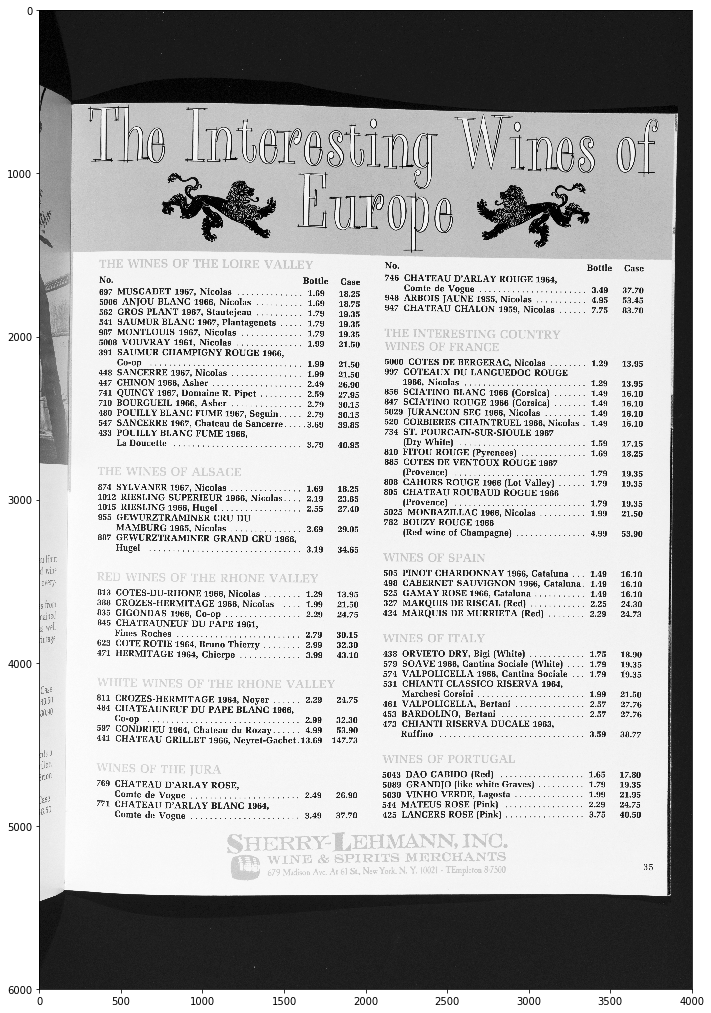

In [7]:
fig = plt.figure(figsize=(12,18))
plt.imshow(testL, cmap='Greys_r')

2


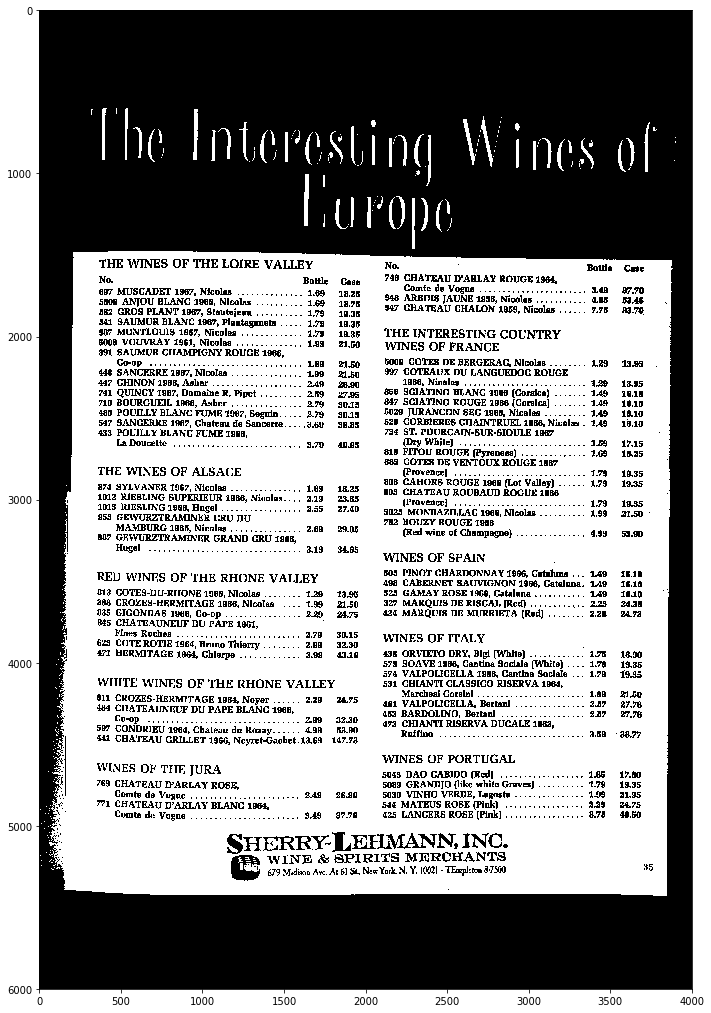

In [8]:
num = 195
plt.figure(figsize=(12, 18))
reduced = num*(np.array(testL)//num)
color_count = Counter(reduced.reshape(6000*4000))
print len(color_count)
fig = plt.figure(figsize=(12,18))
plt.imshow(reduced, cmap='Greys_r')
plt.show()

In [9]:
test_threshold = Image.fromarray(reduced)

In [10]:
test_threshold.save('UCD_Lehmann_0036_BWthreshold.jpg')

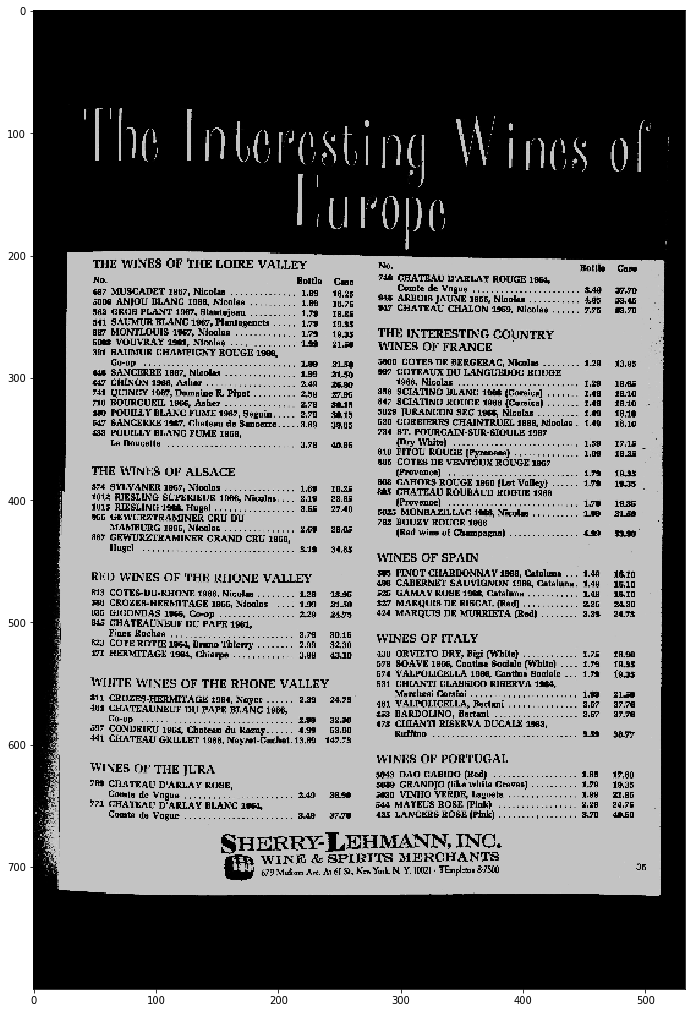

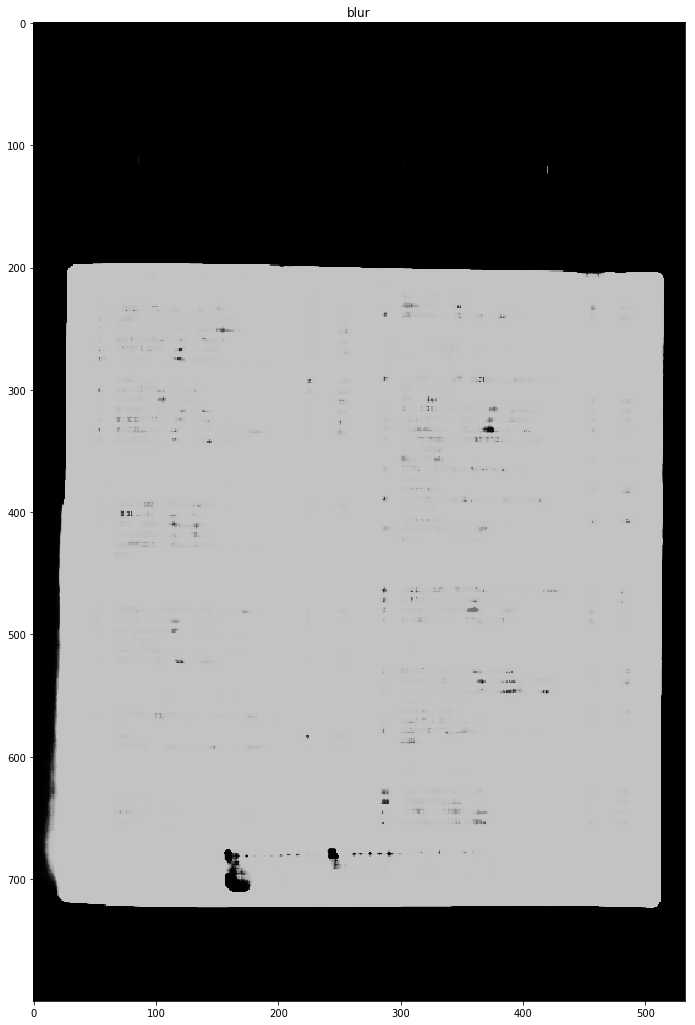

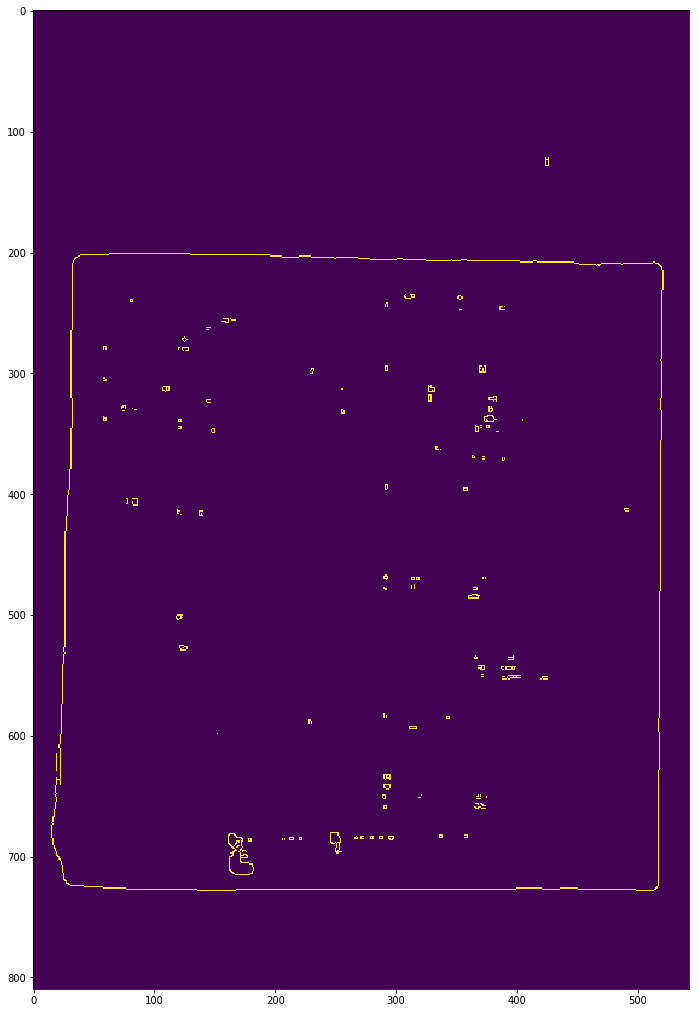

In [15]:
def resize(img, height=800):
    """ Resize image to given height """
    rat = height / img.shape[0]
    return cv2.resize(img, (int(rat * img.shape[1]), height))

image = cv2.imread("UCD_Lehmann_0036_BWthreshold.jpg")
im = resize(image)
fig = plt.figure(figsize=(12,18))
plt.imshow(im, cmap="Greys_r")
# Bilateral filter preserve edges
# img = cv2.bilateralFilter(img, 15, 50, 75)
# fig = plt.figure(figsize=(12,18))
# plt.title('bilateral filter')
# plt.imshow(img, cmap="Greys_r")
# Create black and white image based on adaptive threshold
# img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 4)
# fig = plt.figure(figsize=(12,18))
# plt.title('adaptive threshold')
# plt.imshow(img, cmap="Greys_r")
# Median filter clears small details
img = cv2.medianBlur(im, 11)
fig = plt.figure(figsize=(12,18))
plt.title('blur')
plt.imshow(img, cmap="Greys_r")
# Add black border in case that page is touching an image border
img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
edges = cv2.Canny(img, 200, 250)
fig = plt.figure(figsize=(12,18))
plt.imshow(edges)

In [38]:
# Getting contours  
im2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Finding contour of biggest rectangle
# Otherwise return corners of original image
# Don't forget on our 5px border!
height = edges.shape[0]
width = edges.shape[1]
MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

# Page fill at least half of image, then saving max area found
maxAreaFound = MAX_COUNTOUR_AREA * 0.3

# Saving page contour
pageContour = np.array([[5, 5], [5, height-5], [width-5, height-5], [width-5, 5]])

# Go through all contours
for cnt in contours:
    # Simplify contour
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

    # Page has 4 corners and it is convex
    # Page area must be bigger than maxAreaFound 
    if (len(approx) == 4 and
            cv2.isContourConvex(approx) and
            maxAreaFound < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):

        maxAreaFound = cv2.contourArea(approx)
        pageContour = approx




def fourCornersSort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right """
    # Difference and sum of x and y value
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    # Top-left point has smallest sum...
    # np.argmin() returns INDEX of min
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])

def contourOffset(cnt, offset):
    """ Offset contour, by 5px border """
    # Matrix addition
    cnt += offset
    # if value < 0 => replace it by 0
    cnt[cnt < 0] = 0
    return cnt

# Sort and offset corners
pageContour = fourCornersSort(pageContour[:,0])
pageContour = contourOffset(pageContour, (-5, -5))

pageContour[1][1] -= 50
pageContour[2][1] -= 50

# # Recalculate to original scale - start Points
sPoints = pageContour.dot(image.shape[0]/800)
  
# Using Euclidean distance
# Calculate maximum height (maximal length of vertical edges) and width
height = max(np.linalg.norm(sPoints[0] - sPoints[1]),
             np.linalg.norm(sPoints[2] - sPoints[3]))
width = max(np.linalg.norm(sPoints[1] - sPoints[2]),
             np.linalg.norm(sPoints[3] - sPoints[0]))

# Create target points
tPoints = np.array([[0, 0],
                    [0, height],
                    [width, height],
                    [width, 0]], np.float32)

print(tPoints)

# getPerspectiveTransform() needs float32
if sPoints.dtype != np.float32:
    sPoints = sPoints.astype(np.float32)

# Wraping perspective
M = cv2.getPerspectiveTransform(sPoints, tPoints) 
newImage = cv2.warpPerspective(image, M, (int(width), int(height)))



[[    0.             0.        ]
 [    0.          3510.51269531]
 [ 3660.19213867  3510.51269531]
 [ 3660.19213867     0.        ]]


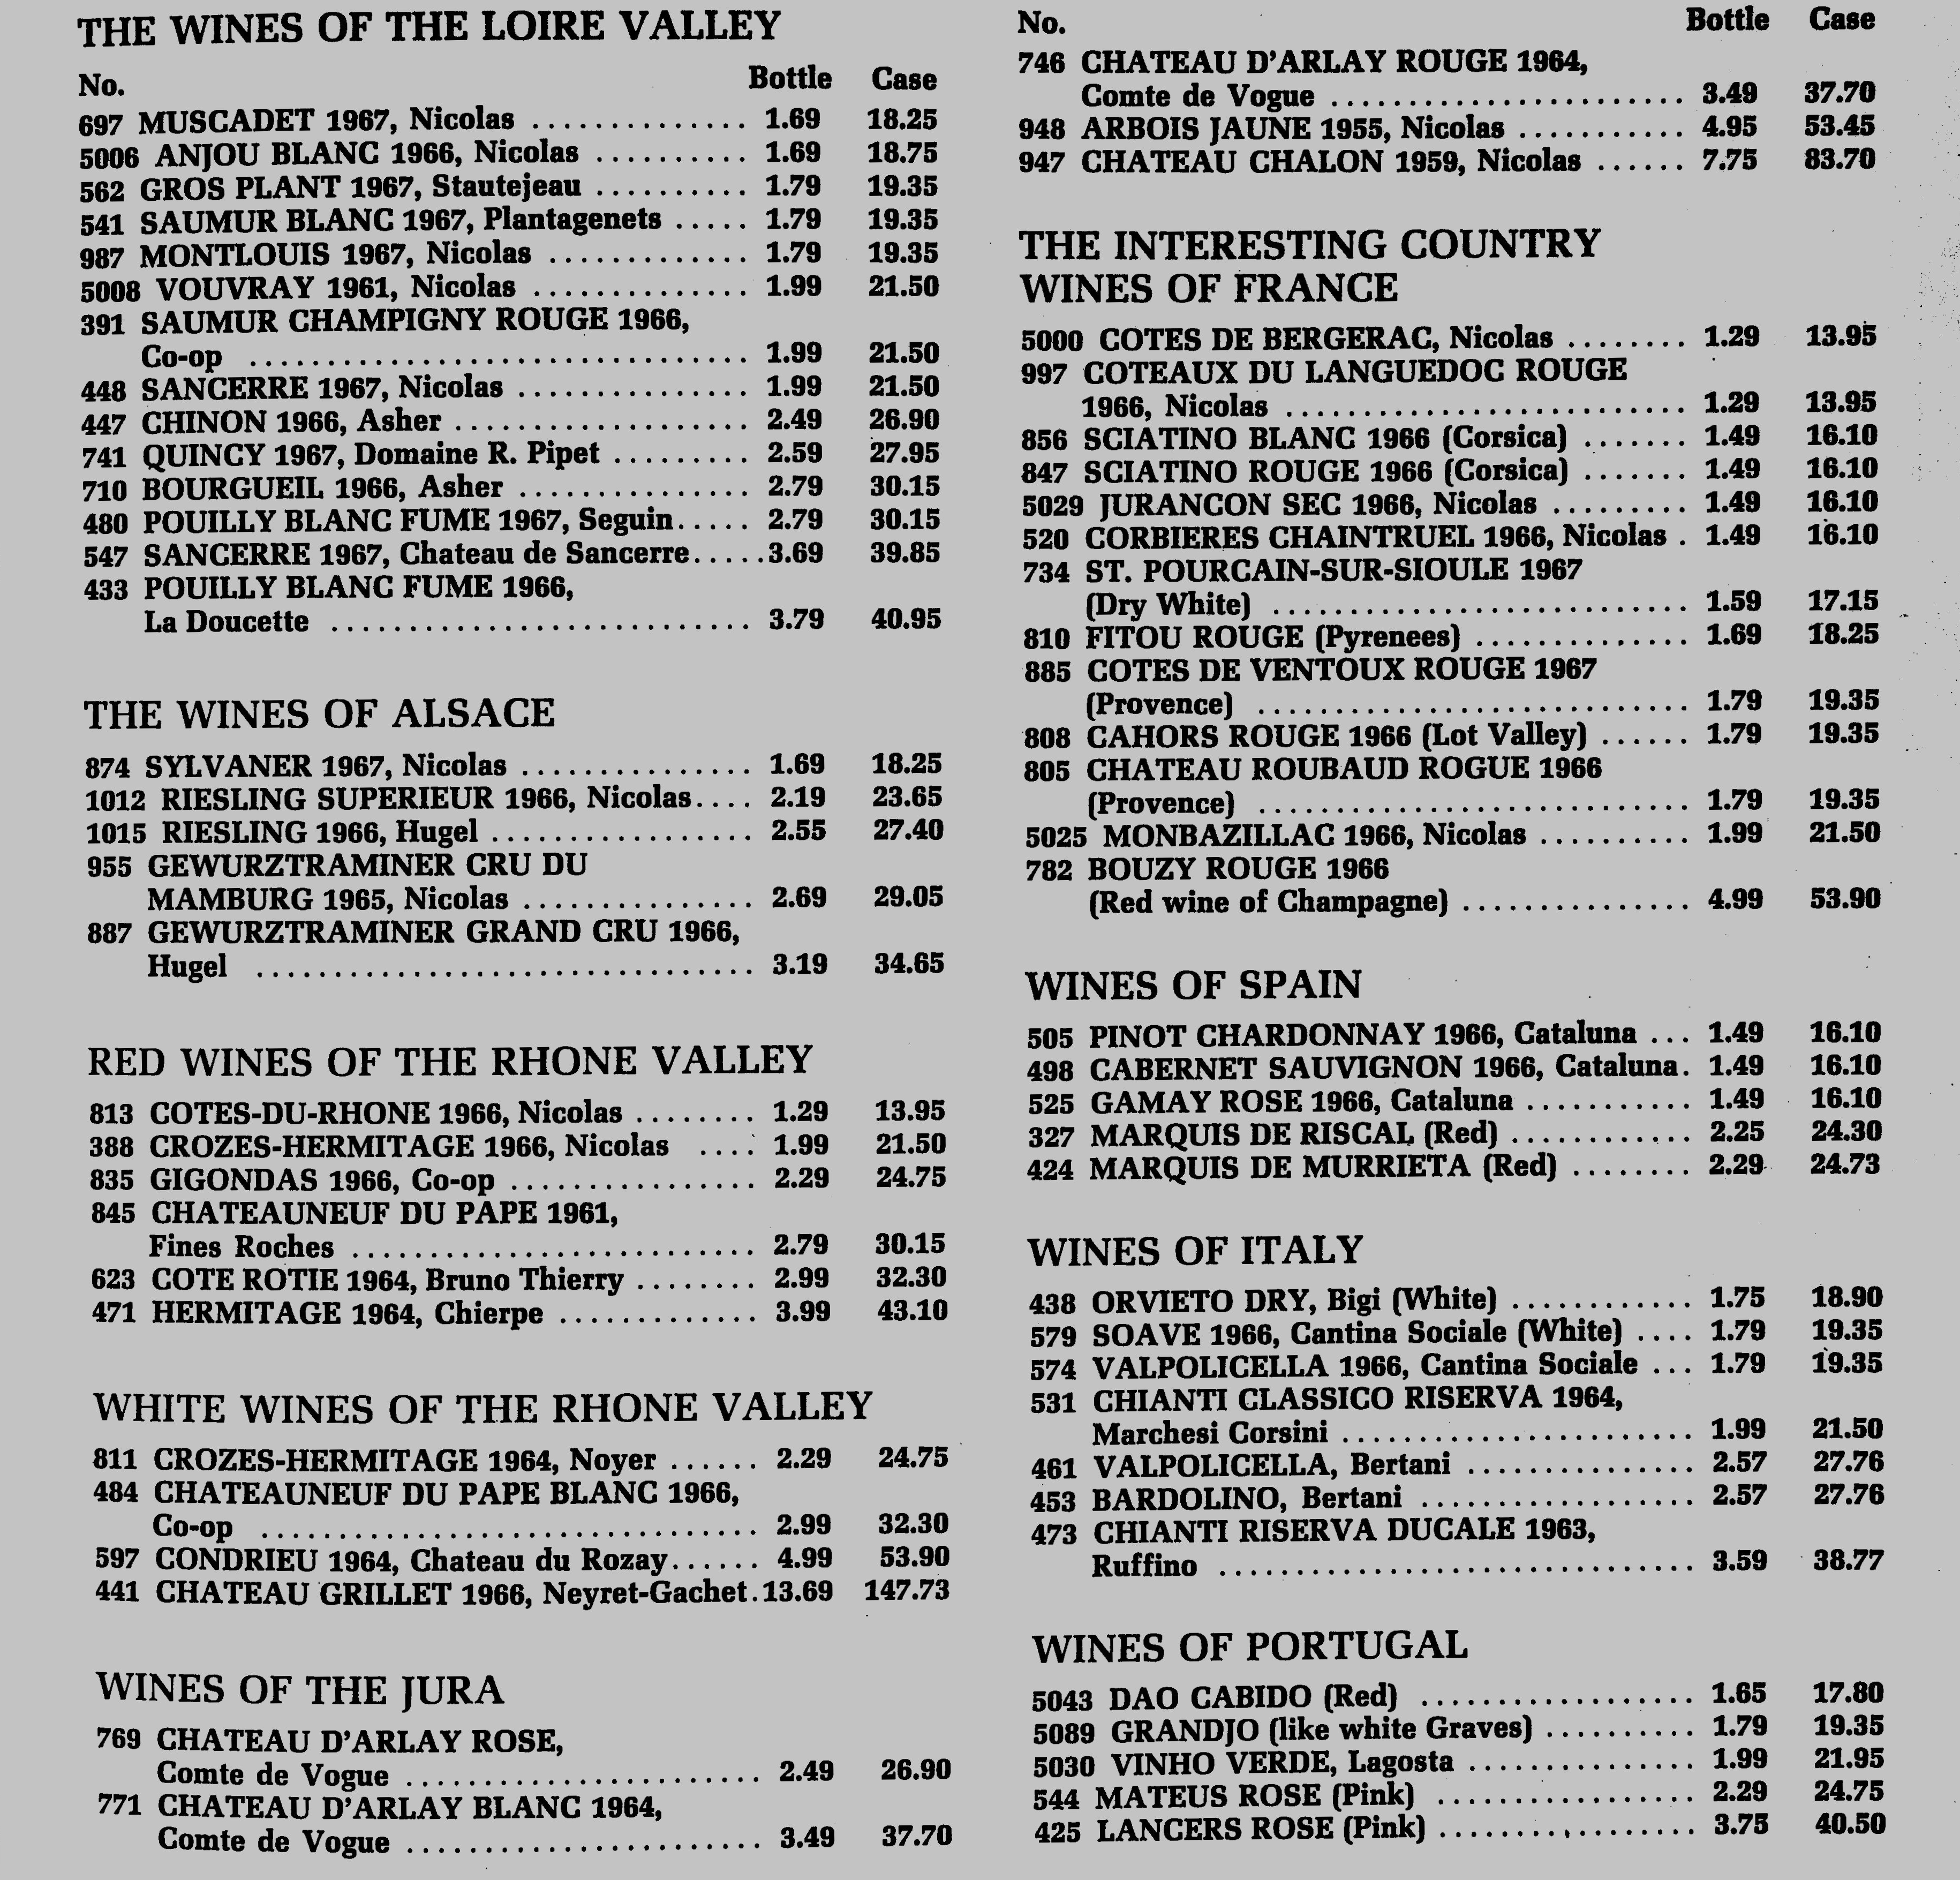

In [39]:
Image.fromarray(newImage)

In [ ]:
plt.figure(figsize=(12, 18))
plt.imshow(newImage)

In [43]:
data = tess.image_to_data(Image.fromarray(newImage), lang='eng')

In [53]:
import pandas as pd

df = [line.split() for line in data.splitlines()]
df = pd.DataFrame(df[1:], columns=df[0])

In [68]:
columns = ['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf']
df[columns] = df[columns].apply(pd.to_numeric)

In [69]:
df.sort_values('top')

level  page_num  block_num  par_num  line_num  word_num  left   top  \
0        1         1          0        0         0         0     0     0   
420      2         1         24        0         0         0  1901    10   
421      3         1         24        1         0         0  1901    10   
422      4         1         24        1         1         0  1901    10   
425      5         1         24        1         1         3  3149    10   
782      2         1         38        0         0         0  3380    12   
784      4         1         38        1         1         0  3380    12   
785      5         1         38        1         1         1  3380    12   
783      3         1         38        1         0         0  3380    12   
9        5         1          1        1         1         6  1155    19   
423      5         1         24        1         1         1  1901    19   
3        4         1          1        1         1         0   145    19   
2        3         1          1        1         0         0   145    19   
1        2         1          1        0         0         0   145    19   
8        5         1          1        1         1         5   900    19   
7        5         1          1        1         1         4   720    20   
6        5         1          1        1         1         3   594    22   
5        5         1          1        1         1         2   317    24   
424      5         1         24        1         1         2  2354    27   
4        5         1          1        1         1         1   145    30   
430      5         1         24        1         2         4  2607    91   
426      4         1         24        1         2         0  1902    91   
431      5         1         24        1         2         5  2834    93   
429      5         1         24        1         2         3  2328    93   
428      5         1         24        1         2         2  2020    93   
427      5         1         24        1         2         1  1902    97   
10       2         1          2        0         0         0   147   120   
11       3         1          2        1         0         0   147   120   
12       4         1          2        1         1         0   147   120   
14       5         1          2        1         1         2  1398   120   
..     ...       ...        ...      ...       ...       ...   ...   ...   
388      5         1         19        2         2         2   296  3350   
390      5         1         19        2         2         4   884  3353   
391      5         1         19        2         2         5  1106  3353   
389      5         1         19        2         2         3   602  3354   
770      5         1         37        1         6         8  3120  3355   
771      5         1         37        1         6         9  3151  3355   
769      5         1         37        1         6         7  2890  3355   
767      5         1         37        1         6         5  2687  3357   
878      5         1         50        1         5         1  3390  3384   
877      4         1         50        1         5         0  3390  3384   
773      4         1         37        1         7         0  1933  3385   
781      5         1         37        1         7         8  3202  3385   
777      5         1         37        1         7         4  2510  3386   
776      5         1         37        1         7         3  2337  3391   
775      5         1         37        1         7         2  2049  3393   
774      5         1         37        1         7         1  1933  3402   
419      5         1         23        1         1         1  1648  3406   
418      4         1         23        1         1         0  1648  3406   
417      3         1         23        1         0         0  1648  3406   
416      2         1         23        0         0         0  1648  3406   
392      3         1         19        3         0   